In [7]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

device = torch.device("cuda:0")

In [37]:
class AutoEncoder(nn.Module):
    def __init__(self, unit_list, activation_list):
        super().__init__()
        self.unit_list = unit_list
        self.activation_list = activation_list
        self.layers = nn.ModuleList()
        
        for input_u, output_u in zip(self.unit_list,self.unit_list[1:]):
            self.layers.append(nn.Linear(input_u, output_u))
            
    
    def forward(self, x):
        
        activation_dict = {'relu':lambda x, layer: F.relu(layer(x)),
                           'sigmoid': lambda x, layer: F.sigmoid(layer(x))}
        
        for layer, activation in zip(self.layers ,self.activation_list):
            x = activation_dict[activation](x, layer)
        return x

    def num_features(self, x):
        
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
    
class ConvolutionalAutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        # encode
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.mp1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 8, 3, padding=1)
        self.mp2 = nn.MaxPool2d(2)
        self.conv3 = nn.Conv2d(8, 8, 3, padding=1)
        self.mp3 = nn.MaxPool2d(2, padding=1)
        
        # decode
        self.conv4 = nn.Conv2d(8, 8, 3, padding=1)
        self.up4 = nn.Upsample(scale_factor=2)
        self.conv5 = nn.Conv2d(8, 8, 3, padding=1)
        self.up5 = nn.Upsample(scale_factor=2)
        self.conv6 = nn.Conv2d(8, 16, 3)
        self.up6 = nn.Upsample(scale_factor=2)
        self.conv7 = nn.Conv2d(16, 1, 3, padding=1)
        
    def forward(self, x):
        x = self.mp1(F.relu(self.conv1(x)))
        x = self.mp2(F.relu(self.conv2(x)))
        x = self.mp3(F.relu(self.conv3(x)))
        
        x = self.up4(F.relu(self.conv4(x)))
        x = self.up5(F.relu(self.conv5(x)))
        x = self.up6(F.relu(self.conv6(x)))
        x = torch.sigmoid(self.conv7(x))
        return x
        
class GaussianNoise(object):
    def __init__(self, noise_factor):
        self.noise_factor = noise_factor
        
    def __call__(self, tensor):
        return (tensor + torch.randn(tensor.size()) * self.noise_factor).clamp(0,1)


In [38]:
# pil images to tensor
transform = transforms.Compose([
    transforms.ToTensor(),
    GaussianNoise(0.5)
])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16, shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=True, num_workers=2)

validation = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
validationset = next(iter(torch.utils.data.DataLoader(validation, batch_size = len(validation))))[0].to(device)#.view(-1, 28 * 28)

#print(next(iter(torch.utils.data.DataLoader(validation, batch_size = len(validation))))[0].to(device).shape)
#print(validationset.view(-1,28*28).shape)

In [39]:

unit_list = [784, 32, 784]
activation_list = ['relu','sigmoid']

model_1 = AutoEncoder(unit_list, activation_list).to(device)
model_2 = ConvolutionalAutoEncoder().to(device)

criterion = nn.BCELoss() #nn.MSELoss()
optimizer_1 = optim.Adam(model_1.parameters(), lr=0.001) #, momentum=0.9)
optimizer_2 = optim.Adam(model_2.parameters(), lr=0.001)

In [40]:
# Train the network
verbose = True
regularize= None # [0] #None #[1]
lmbda = 10e-5

for epoch in range(5):

    for i, data in enumerate(trainloader, 0):

        # get inputs 
        inputs = data[0].to(device)
        #inputs = inputs.view(-1, 28*28)
        optimizer_2.zero_grad()

        # perform forward + backward step
        outputs = model_2(inputs)  
        loss = criterion(outputs, inputs)
        
        if regularize:
            reg_loss = 0
            params = list(model_1.parameters())
            for reg in regularize:
                reg_loss += torch.abs(params[reg]).sum()
            loss += lmbda * reg_loss

        loss.backward()
        optimizer_2.step()
    
    if verbose:
        check = model_2(validationset)
        curr = criterion(check, validationset)
        print('[%d] loss: %.3f' % (epoch + 1, curr))
    

[1] loss: 0.527
[2] loss: 0.522
[3] loss: 0.520
[4] loss: 0.519
[5] loss: 0.518


torch.Size([4, 1, 28, 28])


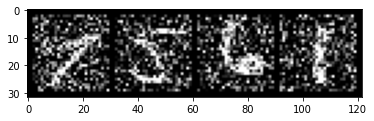

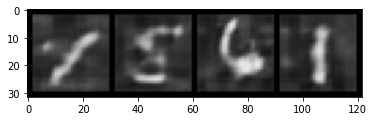

In [41]:

def imshow(img):
    npimg = img.detach().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

iterator = iter(testloader)
images, _ = iterator.next()
images = images.to(device)

imp = images#.view(-1, 28*28)
rec = model_2(imp)
rec.detach()
rec = rec#.reshape(rec.shape[0], 1, 28, 28)
print(images.shape)

# show image
imshow(torchvision.utils.make_grid(images).cpu())
imshow(torchvision.utils.make_grid(rec).cpu())
